## Project the trajectory of the ball with what we have
- missing the right power

[DEBUG] Predicting trajectory with hoop position (41.75, 0.0, 10.0)
[DEBUG] Horizontal velocity magnitude (v_h): 6.74 ft/s
[DEBUG] Horizontal distance to basket: 48.87 ft
[DEBUG] Time to reach the basket (t_basket): 7.2455 s
[DEBUG] Vertical velocity at basket (v_z_basket): -208.41 ft/s
[DEBUG] Predicted Entry Angle: 88.15 degrees
[DEBUG] Predicting trajectory with hoop position (41.75, 0.00, 10.00)
Input Parameters:
  Release Height: 21.41 ft
  Ball Velocity X: 3.76 ft/s
  Ball Velocity Y: -5.60 ft/s
  Ball Velocity Z: 24.70 ft/s
  Release X: 90.58 ft
  Release Y: -1.95 ft
  Gravitational Acceleration: 32.17 ft/s²


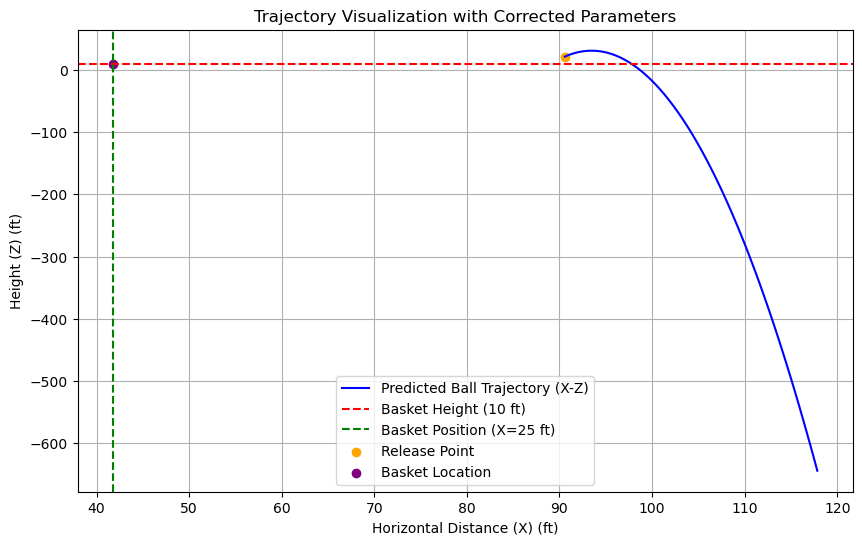

In [4]:
#%%writefile ../../src/freethrow_predictions/ml/trajectory_projection.py

import numpy as np
import matplotlib.pyplot as plt
from mplbasketball.court3d import Court3D, draw_court_3d
import pandas as pd
import logging


logger = logging.getLogger(__name__)

def get_hoop_position(court_type: str = "nba", units: str = "ft", debug: bool = False) -> (float, float, float):
    """
    Calculate the 3D position of the basketball hoop based on court specifications.

    Parameters:
    - court_type (str): Type of the court ('nba', 'wnba', 'ncaa').
    - units (str): Units of measurement ('ft' or 'm').
    - debug (bool): Flag to enable debug logging.

    Returns:
    - x, y, z (float): Coordinates of the hoop in 3D space.
    """
    try:
        court = Court3D(court_type=court_type, units=units)
        params = court.court_parameters
        # The hoop is located a certain distance from the edge of the court
        x = params['court_dims'][0] / 2 - params['hoop_distance_from_edge']
        y = 0.0  # Centered along the y-axis
        z = params['hoop_height']
        if debug:
            logger.debug(f"Calculated hoop position at (x={x}, y={y}, z={z}) for court type '{court_type}' in '{units}' units.")
        return x, y, z
    except KeyError as e:
        logger.error(f"Key error when accessing court parameters: {e}")
        raise
    except Exception as e:
        logger.error(f"Unexpected error in get_hoop_position: {e}")
        raise
    
    
def predict_trajectory(release_height, ball_velocity_x, ball_velocity_y, ball_velocity_z,
                       release_x, release_y, basket_x, basket_y, basket_z,
                       g=32.174, units='imperial', debug=False, result=None):
    """
    Predict the trajectory of the ball based on initial conditions and validate calculations.

    Parameters:
    - release_height, ball_velocity_x, ball_velocity_y, ball_velocity_z: Initial conditions
    - release_x, release_y: Ball release position
    - basket_x, basket_y, basket_z: Hoop position
    - g: Gravitational acceleration
    - units: 'imperial' for feet, 'metric' for meters
    - debug: Whether to print debug information
    - result: Shot result (e.g., 1 for made, 0 for missed)

    Returns:
    - trajectory: List of (x, y, z) points representing the trajectory
    - predicted_entry_angle: Predicted entry angle of the ball in degrees
    - predicted_landing_x, predicted_landing_y: Predicted landing position
    """
    # Debugging information
    if debug:
        print(f"[DEBUG] Predicting trajectory with hoop position ({basket_x}, {basket_y}, {basket_z})")

    # Step 1: Calculate horizontal velocity magnitude
    v_h = np.sqrt(ball_velocity_x**2 + ball_velocity_y**2)
    if debug:
        print(f"[DEBUG] Horizontal velocity magnitude (v_h): {v_h:.2f} ft/s")

    # Step 2: Calculate horizontal distance to the basket
    distance_to_basket = np.sqrt((basket_x - release_x)**2 + (basket_y - release_y)**2)
    if debug:
        print(f"[DEBUG] Horizontal distance to basket: {distance_to_basket:.2f} ft")

    # Step 3: Calculate time to reach the basket
    t_basket = distance_to_basket / v_h
    if debug:
        print(f"[DEBUG] Time to reach the basket (t_basket): {t_basket:.4f} s")

    # Step 4: Calculate vertical velocity at the basket
    v_z_basket = ball_velocity_z - g * t_basket
    if debug:
        print(f"[DEBUG] Vertical velocity at basket (v_z_basket): {v_z_basket:.2f} ft/s")

    # Step 5: Calculate predicted entry angle
    entry_angle_rad = np.arctan2(-v_z_basket, v_h)
    predicted_entry_angle_deg = np.degrees(entry_angle_rad)
    if debug:
        print(f"[DEBUG] Predicted Entry Angle: {predicted_entry_angle_deg:.2f} degrees")

    # Step 6: Generate trajectory points
    num_points = 100
    trajectory = []
    for t in np.linspace(0, t_basket, num_points):
        x = release_x + ball_velocity_x * t
        y = release_y + ball_velocity_y * t
        z = release_height + ball_velocity_z * t - 0.5 * g * t**2
        trajectory.append((x, y, z))
    
    predicted_landing_x, predicted_landing_y = trajectory[-1][0], trajectory[-1][1]

    # Debugging information
    if debug:
        print(f"[DEBUG] Predicting trajectory with hoop position ({basket_x:.2f}, {basket_y:.2f}, {basket_z:.2f})")
        print(f"Input Parameters:")
        print(f"  Release Height: {release_height:.2f} ft")
        print(f"  Ball Velocity X: {ball_velocity_x:.2f} ft/s")
        print(f"  Ball Velocity Y: {ball_velocity_y:.2f} ft/s")
        print(f"  Ball Velocity Z: {ball_velocity_z:.2f} ft/s")
        print(f"  Release X: {release_x:.2f} ft")
        print(f"  Release Y: {release_y:.2f} ft")
        print(f"  Gravitational Acceleration: {g:.2f} ft/s²")
        
    return trajectory, predicted_entry_angle_deg, predicted_landing_x, predicted_landing_y



def extract_parameters_from_dataset(trial_data, units='imperial', debug=False):
    """
    Extract relevant parameters for trajectory prediction from the trial data.

    Parameters:
    - trial_data: DataFrame containing data for a single trial.
    - units: Unit system of the dataset ('imperial' or 'metric').

    Returns:
    - A dictionary of parameters for trajectory prediction.
    """
    # Identify release frame (first frame with release_point_filter == 1)
    release_frame = trial_data[trial_data['release_point_filter'] == 1].iloc[0]

    # Conversion factors
    m_to_ft = 3.28084  # meters to feet

    # Check if units are metric and convert to imperial if necessary
    if units == 'imperial':
        # Assume positions and velocities are in meters and convert to feet
        conversion_factor = m_to_ft
    else:
        conversion_factor = 1.0

    parameters = {
        'release_height': release_frame['ball_z'] * conversion_factor,  # Height of the ball at release
        'release_z': release_frame['ball_z'] * conversion_factor,       # Z position of the ball at release
        'ball_velocity_x': release_frame['ball_velocity_x'] * conversion_factor,  # Horizontal velocity x
        'ball_velocity_y': release_frame['ball_velocity_y'] * conversion_factor,  # Horizontal velocity y
        'ball_velocity_z': release_frame['ball_velocity_z'] * conversion_factor,  # Vertical velocity
        'release_x': release_frame['ball_x'] * conversion_factor,  # x position at release
        'release_y': release_frame['ball_y'] * conversion_factor,  # y position at release
        'entry_angle': trial_data['entry_angle'].iloc[-1],  # Entry angle at the hoop
        'landing_x': trial_data['landing_x'].iloc[-1] / 12,  # Convert inches to feet
        'landing_y': trial_data['landing_y'].iloc[-1] / 12,  # Convert inches to feet
        'result': trial_data['result'].iloc[0]  # Shot result
    }

    # Add debug output for parameter extraction
    if debug:
        print("[DEBUG] Extracted Parameters:")
        for k, v in parameters.items():
            print(f"  {k}: {v:.2f}")

    return parameters


# Load data from the specified CSV file
data_path = "../../../data/processed/final_granular_dataset.csv"
final_granular_df_with_stats = pd.read_csv(data_path)


# # Example Usage
# from  import create_reference_table
# from  import get_column_definitions
# reference_df = create_reference_table()
# # Column Definitions
# column_definitions = get_column_definitions()
# print("Column Definitions for the Dataset:\n", column_definitions)

# Validate and predict trajectory for a single trial
trial_id_to_visualize = 'T0088'
trial_data = final_granular_df_with_stats[
    final_granular_df_with_stats['trial_id'] == trial_id_to_visualize
].sort_values(by='frame_time')

# Validate and predict trajectory for a single trial
params = extract_parameters_from_dataset(trial_data)
# Retrieve hoop position
hoop_x, hoop_y, hoop_z = get_hoop_position(court_type='nba', units='ft', debug=True)

# Predict trajectory using corrected parameters
trajectory, predicted_entry_angle, predicted_landing_x, predicted_landing_y = predict_trajectory(
    release_height=params['release_height'],
    ball_velocity_x=params['ball_velocity_x'],
    ball_velocity_y=params['ball_velocity_y'],
    ball_velocity_z=params['ball_velocity_z'],
    release_x=params['release_x'],
    release_y=params['release_y'],
    basket_x=hoop_x,
    basket_y=hoop_y,
    basket_z=hoop_z,
    units='imperial',
    debug=True,
    result=params['result']
)

# Visualize the trajectory
x_vals, y_vals, z_vals = zip(*trajectory)
plt.figure(figsize=(10, 6))
plt.plot(x_vals, z_vals, label="Predicted Ball Trajectory (X-Z)", color='blue')
plt.axhline(hoop_z, color='red', linestyle='--', label="Basket Height (10 ft)")
plt.axvline(hoop_x, color='green', linestyle='--', label="Basket Position (X=25 ft)")
plt.scatter(params['release_x'], params['release_z'], color='orange', label="Release Point")
plt.scatter(hoop_x, hoop_z, color='purple', label="Basket Location")
plt.xlabel("Horizontal Distance (X) (ft)")
plt.ylabel("Height (Z) (ft)")
plt.title("Trajectory Visualization with Corrected Parameters")
plt.legend()
plt.grid()
plt.show()
